<a href="https://colab.research.google.com/github/usafhulk/Neural-Networks-with-Keras/blob/main/Classification%20and%20Captioning%20ipynd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [ ]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Part 1: Classifying the Problem

#### 1.1 Dataset Preperation

In [ ]:
#Set the batch size,epochs
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [ ]:
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")

    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
Extracted aircraft_damage_dataset_v1.tar successfully.


In [ ]:
# showing the content of the folder

import os

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

# Assuming 'extracted_folder' holds the name of the extracted dataset directory
extracted_folder = "aircraft_damage_dataset_v1"
print_directory_structure(extracted_folder)

aircraft_damage_dataset_v1/
    test/
        dent/
            100_12_JPG_jpg.rf.c9eba14c33080322c8039295a4564509.jpg
            213_1_JPG_jpg.rf.a38a31b48f2206fbf7f0cf5e49736dc7.jpg
            149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg
            154_8_JPG_jpg.rf.b1f70e012515aa49e1d965b92198be63.jpg
            151_24_JPG_jpg.rf.8e7b0f67da38bf329a56fc46fd34f92f.jpg
            156_19_JPG_jpg.rf.ce86a8763333f7a0736a24f0537c38a3.jpg
            145_21_JPG_jpg.rf.d2d9d14202775dd0f28a3db931ae057e.jpg
            146_21_JPG_jpg.rf.62814adf2e016eb273290756cff2e993.jpg
            100_6_JPG_jpg.rf.5735b6c11e91aeff859f3d34fd772ddb.jpg
            135_4_JPG_jpg.rf.7145e74e4655919b4bc24c9648592e32.jpg
            161_6_JPG_jpg.rf.4ade35715c20be78546832880ae2bed7.jpg
            136_15_JPG_jpg.rf.35554276cb237619af1cf7fb465e3f46.jpg
            136_14_JPG_jpg.rf.ebc6db2f4244eb3f538fc7d8f22af435.jpg
            17_16_JPG_jpg.rf.1bbfc7fc59a41c5e6a70a5628fe55310.jpg
            151_

In [ ]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

#### 1.2 Data Preprocessing

In [ ]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 300 images belonging to 2 classes.


## Create a `valid_generator` using the `valid_datagen` object


*   **directory** should be set to `valid_dir`.
*   **class_mode** should be set to `'binary'`.
*   **seed** should be set to `seed_value`.
*   **batch_size** should be set to `batch_size`.
*   **shuffle** should be set to `False`.
*   **target_size** should be set to `(img_rows, img_cols)`.


In [ ]:
valid_generator = valid_datagen.flow_from_directory(
    directory = valid_dir,
    class_mode = 'binary',
    seed = seed_value,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


##  Create a `test_generator` using the `test_datagen` object



*   **directory** should be set to `test_dir`.
*   **class_mode** should be set to `'binary'`.
*   **seed** should be set to `seed_value`.
*   **batch_size** should be set to `batch_size`.
*   **shuffle** should be set to `False`.
*   **target_size** should be set to `(img_rows, img_cols)`.



In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    class_mode = 'binary',
    seed = seed_value,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


## Load the pre-trained model VGG16

Set <code>weights='imagenet'</code>,<code>include_top=False</code>,<code>input_shape=(img_rows, img_cols, 3)</code>



In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## Compile the model

compile the model using the following parameters:

*   **loss**: `'binary_crossentropy'`.
*   **optimizer**: `=Adam(learning_rate=0.0001)`.
*   **metrics**: `['accuracy']`.




In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

train the model using the following parameters:

*   **train_data**: `train_generator`
*   **epochs**: `n_epochs`
*   **validation_data**: `valid_generator`




In [ ]:
history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator,
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 241s 24s/step - accuracy: 0.5192 - loss: 0.7190 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 217s 22s/step - accuracy: 0.7010 - loss: 0.5582 - val_accuracy: 0.6979 - val_loss: 0.5821
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 213s 23s/step - accuracy: 0.7865 - loss: 0.4846 - val_accuracy: 0.7188 - val_loss: 0.5486
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 211s 22s/step - accuracy: 0.8258 - loss: 0.3879 - val_accuracy: 0.6562 - val_loss: 0.6457
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 214s 22s/step - accuracy: 0.8663 - loss: 0.3421 - val_accuracy: 0.7083 - val_loss: 0.5098


In [ ]:
train_history = model.history.history

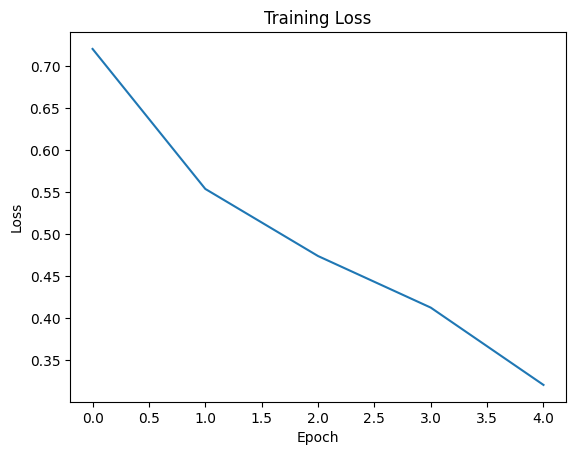

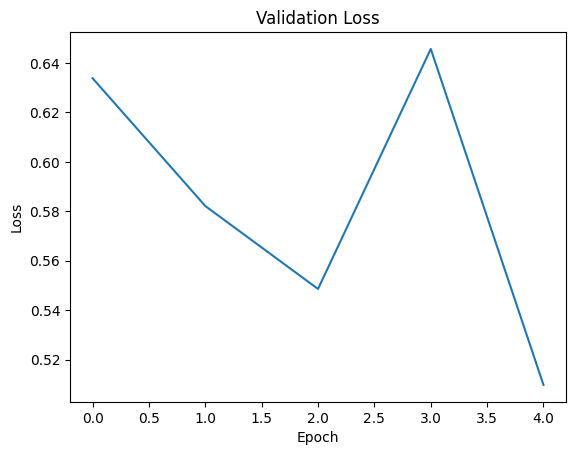

In [ ]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

## Plot accuracy curves for training and validation sets



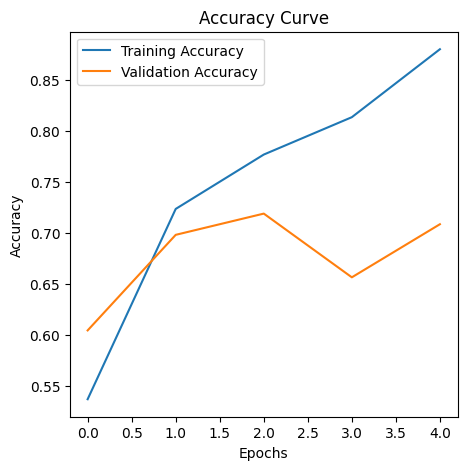

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6875 - loss: 0.7326
Test Loss: 0.7326
Test Accuracy: 0.6875


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


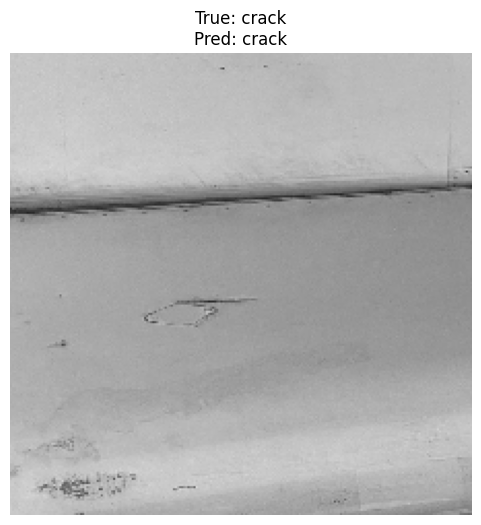

In [ ]:
index_to_plot = 1
test_model_on_image(test_generator, model, index_to_plot=index_to_plot)

##  Image Captioning and Summarization using BLIP Pretrained Model

BLIP (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, learners will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.


#### Key Steps:

- **Image Loading and Preprocessing:** The code will begin by loading images from a file path, then converting and processing them into a format suitable for input to the BLIP model.
  
- **Text Generation:** Depending on the task, whether generating a caption or summary, the BLIP model will generate corresponding text based on the processed image.
  
- **Custom Keras Layer:** A custom Keras layer is a user-defined layer that extends Keras' built-in functionality.Here custom Keras layer will be implemented to wrap the BLIP model. This layer will handle the task-specific processing (captioning or summarizing) and integrate smoothly into a TensorFlow/Keras environment.


In [ ]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

## 2.1 Loading BLIP Model

#### Load the BLIP Model and Processor from Hugging Face

Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

- **BlipProcessor:** This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

- **BlipForConditionalGeneration:** This is the model itself, responsible for generating captions or summaries based on the processed image.



In [ ]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

#### Custom Keras Layer: BlipCaptionSummaryLayer

Next, we define a custom `tf.keras.layers.Layer` class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model. To create a custom Keras layer, we need to subclass `tf.keras.layers.Layer` and implement the required methods.

#### **BlipCaptionSummaryLayer Class:**

This custom Keras layer integrates image preprocessing and text generation using a pretrained BLIP model.

- **`__init__`**: This constructor method initializes the `BlipCaptionSummaryLayer` class by setting up the BLIP processor and model.
  
- **`call`**: This method defines the operations or transformations applied to the input data as it passes through the layer.

- **`process_image`**: The `process_image` method contains the custom logic for loading the image, preprocessing it, generating the text (either a caption or a summary) using the BLIP model, and returning the generated result.


In [ ]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


##  Implement a Helper Function to Use the Custom Keras Layer

 implement a helper function `generate_text` that utilizes the custom `BlipCaptionSummaryLayer` Keras layer to generate captions or summaries for a given image. The function will accept an image path and a task type (caption or summary), process the image using the BLIP model, and return the generated text.



#### Create the Helper Function `generate_text`:
The function will accept following parameters:

* **`image_path`**: The path to the image file (in tensor format).
* **`task`**: The type of task to perform, which can either be "caption" or "summary" (in tensor format).
  
Inside the function:
1. Create an instance(blip_layer) of the `BlipCaptionSummaryLayer`.
2. Call this layer with the provided image path and task type.
3. Return the generated caption or summary as the output.




In [ ]:
def generate_text(image_path, task):
  blip_layer = BlipCaptionSummaryLayer(processor, model)
  generated_text = blip_layer(image_path, task)
  return generated_text

In [ ]:

# Path to an example image
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


## Generate a caption for an image using the using BLIP pretrained model

- Use the image_path variable given below to load the image. Run the cell to before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task



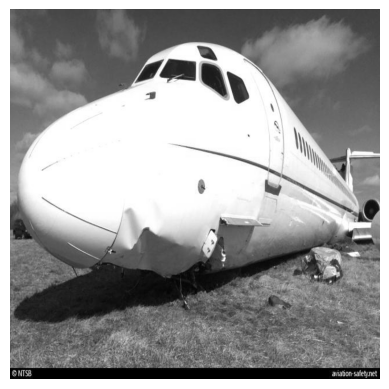

In [ ]:
# We will use the following image to display Caption and Summary for Task 9 and 10
# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [ ]:
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

Caption: this is a picture of a plane that was sitting on the ground in a field


## Generate a summary of an image using BLIP pretrained model

- Use the image_path variable given below to load the image. Run the cell before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task

In [ ]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [ ]:
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

Caption: this is a picture of a plane that was sitting on the ground in a field
